# README Prophesy
By Nicole Garza & Michael P. Moran

## TODO

- Task Division
    - Michael
        - [X] Remove repos with no programming language
        - [X] Fit the vectorizer to the X_test, not the whole thing pre-split!!
        - [X] remove non-english repos
        - [ ] look at run on words
        - [ ] add function to make a prediction on a given README; make sure other requirements of the project are done as well
        - [X] throw out most frequent words and most frequent bigrams. I think they may be throwing the model off.
        - [ ] use as features only words unique to each language
        - [ ] Also try rebalancing the dataset so Javascript and Java are not overrepresented
    - Nicole
        - [X] Bag of words modeling
        - [X] Add sentiment feature
        - [ ] add number of words of README as feature
        - [X] try stemmed and clean

  ## Table of contents
1. [Project Planning](#project-planning)
1. [Acquisition](#acquisition)
1. [Preparation](#preparation)
1. [Exploration](#exploration)
1. [Modeling](#modeling)

## Project Planning <a name="project-planning"></a>

### Goals

A model that predicts the predominant language of a GitHub repo given the repo's README file

### Deliverables

* Jupyter notebook containing analysis
* One or two google slides suitable for a general audience that summarize findings. Include a well-labelled visualization in your slides.
* A function taking a README as input and outputting the language

### Project Conclusions

* Acquisition
    * Acquiring the data was challenging. We had two main options: (1) scrape the HTML-rendered search results and (2) use the JSON API. We chose to use the JSON API because it allowed dictionary-based access to the information we needed. We did not have to identify the correct HTML tag or do anything else associated with scraping. The JSON API also allowed us to download many more repos faster than scraping the HTML.
    * We also had the choice of scraping the HTML rendered README or downloading the raw README file. Acquiring the raw README was significantly easier, so we chose thisGitHub's API only returns a raw README file, not the rendered HTML version (although it's available in a link).
* Preparation
    * We processed the raw README using a markdown module, which rendered it to HTML. We then used Beautiful Soup to extract the text. We removed single character words (which was pointless because the sklearn vectorizers do this already) and also removed links.
    * We also removed non-English repos given that we are ASCII standardizing. Thus, our model is for English repos only. We dropped repos with no programming language, so our model has this limitation.
* Exploration
    * The most common languages were JavaScript, Java, Python, C++, and HTML. JavaScript and Java are heavily overrepresented. If we had more time, we would have rebalanced the dataset, so they do not predominate.
    * The most common words look like generic programming terms ("use", "code", "file") and do not appear to be useful indicators of the language (except for JavaScript, which we hope would indicate JavaScript). Also, there is significant overlap of the most common bigrams for the languages. Thus, bigrams may not perform better than single words.
    * We have problems with runon words. If we had more time, this is something to address.
* Modeling
    * Our model predicts for only the top 5 most common repos. Thus, an input repo that is not predominately programmed in one of these languages will automatically be wrong. We tried to use an "other" category but this sorely hurt our models' performance. Accuracy plummeted about 20-30 percentage points on average. It may be because "other" had such diversity of language it was pulling in repos it shouldn't. We tried using bigrams, but these did not give us better predictive power, which was not expected. The bigrams appeared to be unique overall to the individual languages.
    * We also used lemmatized, stemmed, and clean version of the README. Clean appeared to perform on par with stemmed. Not really sure why at this time.
    * With more time, we would add the number of words in the README as a feature.
    * KNN and Random Forest give us our best results

### Data Dictionary & Domain Knowledge

### Hypotheses
* I expect to see JavaScript and Python as the two most common languages used based on current popularity
    - Yes, among the top 100 most-forked repos, but it's Java and Javascript when we grab repos outside the top 100.
* The primary language may be mentioned in the README. But some repositories mention multiple languages, so this may interfere with this method.
* The number of words may be an indication of the language. Older repositories are probably written in certain languages and because of their age, may have more documentation.
* The sentiment score of the README may be indicative of the language
    - No. The languages all have a sentiment score of 0, except for C++

### Thoughts & Questions

* The code in many repositories are written in multiple languages. We will go with the most predominant language.
* Take out repos with No programming language
* After taking out the "Other" programming language category. The accuracy of the model shot way up! I believe this category acquired so much language that was used in the top5 repos the models were having difficulty choosing the class.


### Prepare the Environment

In [1]:
import os
import json
from pprint import pprint
import re
import unicodedata
from functools import reduce, partial
from copy import deepcopy
from markdown import markdown

import requests
from bs4 import BeautifulSoup
import pandas as pd

import env

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

from scipy.spatial.distance import cdist
from scipy.cluster.vq import kmeans2, whiten
from sklearn.cluster import KMeans
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from langdetect import detect

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## Acquisition <a name="acquisition"></a>

**Grab data for 1000 most forked repos on GitHub**

**Constants**

In [2]:
NUM_PER_PAGE = 50
PAGES = 20
API_URL = f"https://api.github.com/search/repositories?q=stars:%3E1&sort=forks&order=desc&per_page={NUM_PER_PAGE}"
HEADERS = {"Authorization": f"token {env.oauth_token}"}
REPO_FILE_NAME = "repos.json"

**Download the data or read from repos.json file**

In [3]:
def github_api_req(page):
    data = requests.get(API_URL + f"&page={page}", headers=HEADERS).json()
    return data["items"]


def readme_url(contents_url):
    # find name of README file and construct a link to the raw text of the readme
    for file in requests.get(contents_url, headers=HEADERS).json():
        if file["name"].lower().startswith("readme"):
            return file["download_url"]


def load_repo_metadata(use_cache=True):
    if use_cache and os.path.exists(REPO_FILE_NAME):
        with open(REPO_FILE_NAME, "r") as f:
            contents = json.load(f)
        return contents
    else:
        response = []
        for num in range(1, PAGES + 1):
            response += github_api_req(num)
        for repo in response:
            # get link to contents of repo
            contents_url = repo["contents_url"][
                :-8
            ]  # remove last 8 characters to get working URL

            rmurl = readme_url(contents_url)

            readme_text = None  # sometimes there is no valid URL to the readme
            if rmurl:
                # download README text
                readme_text = requests.get(rmurl, headers=HEADERS).text

            repo["readme"] = readme_text
        with open(REPO_FILE_NAME, "w") as f:
            json.dump(response, f)
        return response


all_repo_data = load_repo_metadata()

In [4]:
all_repo_data[:3]

[{'id': 14204342,
  'node_id': 'MDEwOlJlcG9zaXRvcnkxNDIwNDM0Mg==',
  'name': 'datasharing',
  'full_name': 'jtleek/datasharing',
  'private': False,
  'owner': {'login': 'jtleek',
   'id': 1571674,
   'node_id': 'MDQ6VXNlcjE1NzE2NzQ=',
   'avatar_url': 'https://avatars2.githubusercontent.com/u/1571674?v=4',
   'gravatar_id': '',
   'url': 'https://api.github.com/users/jtleek',
   'html_url': 'https://github.com/jtleek',
   'followers_url': 'https://api.github.com/users/jtleek/followers',
   'following_url': 'https://api.github.com/users/jtleek/following{/other_user}',
   'gists_url': 'https://api.github.com/users/jtleek/gists{/gist_id}',
   'starred_url': 'https://api.github.com/users/jtleek/starred{/owner}{/repo}',
   'subscriptions_url': 'https://api.github.com/users/jtleek/subscriptions',
   'organizations_url': 'https://api.github.com/users/jtleek/orgs',
   'repos_url': 'https://api.github.com/users/jtleek/repos',
   'events_url': 'https://api.github.com/users/jtleek/events{/privac

## Preparation <a name="preparation"></a>

In [5]:
def all_repo_metadata(api_data):
    return [
        repo_metadata(repo) for repo in api_data if repo["readme"] is not None
    ]


def repo_metadata(api_dict):
    # store the id, username, name of repo
    repo_id = api_dict["id"]
    user_name = api_dict["owner"]["login"]
    repo_name = api_dict["name"]

    # find the predominant programming language
    lang = api_dict["language"]

    # render the markdown to html
    html = markdown(api_dict["readme"])
    # and extract the text from the html
    soup = BeautifulSoup(html, "html.parser")
    readme_text = soup.text

    return dict(
        repo_id=repo_id,
        user_name=user_name,
        repo_name=repo_name,
        lang=lang,
        readme=readme_text,
    )


some_repo_data = all_repo_metadata(all_repo_data)

In [6]:
some_repo_data[:3]

[{'repo_id': 14204342,
  'user_name': 'jtleek',
  'repo_name': 'datasharing',
  'lang': None,
  'readme': 'How to share data with a statistician\nThis is a guide for anyone who needs to share data with a statistician or data scientist. The target audiences I have in mind are:\n\nCollaborators who need statisticians or data scientists to analyze data for them\nStudents or postdocs in various disciplines looking for consulting advice\nJunior statistics students whose job it is to collate/clean/wrangle data sets\n\nThe goals of this guide are to provide some instruction on the best way to share data to avoid the most common pitfalls\nand sources of delay in the transition from data collection to data analysis. The Leek group works with a large\nnumber of collaborators and the number one source of variation in the speed to results is the status of the data\nwhen they arrive at the Leek group. Based on my conversations with other statisticians this is true nearly universally.\nMy strong fee

**Clean, stem, lemmatize, and remove stopwords**

In [7]:
# right to left
def compose(*fns):
    return partial(reduce, lambda x, f: f(x), reversed(fns))


# applies in the order supplied
def pipe(v, *fns):
    return reduce(lambda x, f: f(x), fns, v)


def map_exhaust(func, *iters):
    for args in zip(*iters):
        func(*args)


def normalize_text(text):
    return (
        unicodedata.normalize("NFKD", text)
        .encode("ascii", "ignore")
        .decode("utf-8", "ignore")
    )


def remove_chars(text):
    return re.sub(r"[^A-Za-z0-9 ]", "", re.sub(r"\s", " ", text))


def remove_bogus_words(text):
    no_single_words = re.sub(r"\s.{1}\s", "", text)  # remove single characters
    return re.sub(r"http.{1,}[\s\.]*", "", no_single_words)  # remove links


def basic_clean(text):
    return pipe(text, str.lower, normalize_text, remove_chars)


def tokenize(text):
    tokenizer = ToktokTokenizer()
    return tokenizer.tokenize(text, return_str=True)


def stem(text):
    ps = nltk.porter.PorterStemmer()
    return " ".join([ps.stem(word) for word in text.split()])


def lemmatize(text):
    wnl = nltk.stem.WordNetLemmatizer()
    lemmas = [wnl.lemmatize(word) for word in text.split()]
    return " ".join(lemmas)


def remove_stopwords(text, include=[], exclude=[]):
    stopword_list = stopwords.words("english")

    map_exhaust(stopword_list.remove, exclude)
    map_exhaust(stopword_list.append, include)

    removed = " ".join([w for w in text.split() if w not in stopword_list])

    #     print("Removed", len(text.split()) - len(removed.split()), "words")
    return removed


def prep_readme(repo_data):
    copy = deepcopy(repo_data)

    copy["clean"] = pipe(
        copy["readme"],
        basic_clean,
        tokenize,
        remove_stopwords,
        remove_bogus_words,
    )

    copy["stemmed"] = stem(copy["clean"])

    copy["lemmatized"] = lemmatize(copy["clean"])

    return copy


def prep_readme_data(all_repo_data):
    return [prep_readme(repo) for repo in all_repo_data]


df = pd.DataFrame(prep_readme_data(some_repo_data))

any single j's?

In [8]:
df[df.clean.str.contains(" j ")]

Empty DataFrame
Columns: [clean, lang, lemmatized, readme, repo_id, repo_name, stemmed, user_name]
Index: []

any links?

In [9]:
df[df.clean.str.contains(" http")]

Empty DataFrame
Columns: [clean, lang, lemmatized, readme, repo_id, repo_name, stemmed, user_name]
Index: []

### Summarize Data

In [10]:
df.head()

clean        lang  \
0  share data statistician guide anyone needs sha...        None   
1  introduction second programming assignment req...           R   
2  well hello repository meant provide example fo...        HTML   
3  documentation tensorflow open source software ...         C++   
4  bootstrap sleek intuitive powerful frontend fr...  JavaScript   

                                          lemmatized  \
0  share data statistician guide anyone need shar...   
1  introduction second programming assignment req...   
2  well hello repository meant provide example fo...   
3  documentation tensorflow open source software ...   
4  bootstrap sleek intuitive powerful frontend fr...   

                                              readme   repo_id  \
0  How to share data with a statistician\nThis is...  14204342   
1  Introduction\nThis second programming assignme...  15917132   
2  Well hello there!\nThis repository is meant to...   1300192   
3  \n\n\n\n| Documentation |\n|-----------------|...  45717250   
4  \n\n\n\n\nBootstrap\n\n  Sleek, intuitive, and...   2126244   

                repo_name                                            stemmed  \
0             datasharing  share data statistician guid anyon need share ...   
1  ProgrammingAssignment2  introduct second program assign requir writefu...   
2             Spoon-Knife  well hello repositori meant provid exampl fork...   
3              tensorflow  document tensorflow open sourc softwar librari...   
4               bootstrap  bootstrap sleek intuit power frontend framewor...   

    user_name  
0      jtleek  
1      rdpeng  
2     octocat  
3  tensorflow  
4        twbs

In [11]:
df.describe(include="all")

clean        lang lemmatized  \
count    994         881        994   
unique   965          43        964   
top           JavaScript              
freq       9         242          9   
mean     NaN         NaN        NaN   
std      NaN         NaN        NaN   
min      NaN         NaN        NaN   
25%      NaN         NaN        NaN   
50%      NaN         NaN        NaN   
75%      NaN         NaN        NaN   
max      NaN         NaN        NaN   

                                                   readme       repo_id  \
count                                                 994  9.940000e+02   
unique                                                977           NaN   
top     Generated files\nThis repository contains gene...           NaN   
freq                                                    5           NaN   
mean                                                  NaN  3.232594e+07   
std                                                   NaN  3.610520e+07   
min                                                   NaN  3.314000e+03   
25%                                                   NaN  3.747378e+06   
50%                                                   NaN  2.013301e+07   
75%                                                   NaN  4.895340e+07   
max                                                   NaN  1.777365e+08   

       repo_name stemmed user_name  
count        994     994       994  
unique       965     964       756  
top      Arduino           udacity  
freq           4       9        19  
mean         NaN     NaN       NaN  
std          NaN     NaN       NaN  
min          NaN     NaN       NaN  
25%          NaN     NaN       NaN  
50%          NaN     NaN       NaN  
75%          NaN     NaN       NaN  
max          NaN     NaN       NaN

In [12]:
df.lang.value_counts(dropna=False)

JavaScript                  242
Java                        137
NaN                         113
Python                       91
HTML                         46
C++                          45
Ruby                         36
Go                           31
C                            30
PHP                          29
Jupyter Notebook             26
CSS                          26
Shell                        19
Objective-C                  19
C#                           17
TypeScript                   15
Swift                        12
Kotlin                        9
Vue                           7
Scala                         5
TeX                           5
PowerShell                    4
Vim script                    3
Lua                           3
Groovy                        2
Makefile                      2
Rust                          2
R                             2
Dockerfile                    1
Batchfile                     1
ApacheConf                    1
Julia   

### Remove repos that have one or fewer words

In [13]:
print("Before removal:", len(df))
df = df[df.clean.apply(lambda s: len(s.split()) > 1)]
print("After removal:", len(df))

Before removal: 994
After removal: 962


### Remove Non-English Repos

**What does the language spread look like?**

In [14]:
df.clean.apply(detect).value_counts()

en    871
fr     27
ca      8
af      6
es      5
nl      5
et      5
cy      5
ro      4
de      4
it      4
sq      3
sl      2
sv      2
vi      2
sk      2
pt      2
no      1
tl      1
da      1
so      1
hr      1
Name: clean, dtype: int64

In [15]:
print("Before removal:", len(df))
df = df[df.clean.apply(detect) == "en"]
print("After removal:", len(df))

Before removal: 962
After removal: 875


### Check Missing Values

#### Remove repos that have no programming language

In [16]:
len(df)

875

In [17]:
df.isna().sum()

clean          0
lang          94
lemmatized     0
readme         0
repo_id        0
repo_name      0
stemmed        0
user_name      0
dtype: int64

In [18]:
df = df.dropna()

In [19]:
df.isna().sum()

clean         0
lang          0
lemmatized    0
readme        0
repo_id       0
repo_name     0
stemmed       0
user_name     0
dtype: int64

In [20]:
len(df)

781

#### Most common languages

In [21]:
langs = pd.concat(
    [df.lang.value_counts(dropna=False), df.lang.value_counts(dropna=False, normalize=True)], axis=1
)
langs.columns = ["n", "percent"]
langs

n   percent
JavaScript                218  0.279129
Java                      116  0.148528
Python                     76  0.097311
C++                        44  0.056338
HTML                       36  0.046095
Ruby                       33  0.042254
Go                         28  0.035851
C                          28  0.035851
PHP                        27  0.034571
CSS                        24  0.030730
Jupyter Notebook           24  0.030730
Shell                      17  0.021767
C#                         17  0.021767
Objective-C                16  0.020487
TypeScript                 13  0.016645
Swift                      10  0.012804
Kotlin                      9  0.011524
Vue                         5  0.006402
Scala                       5  0.006402
TeX                         4  0.005122
Lua                         3  0.003841
PowerShell                  3  0.003841
Makefile                    2  0.002561
Vim script                  2  0.002561
Groovy                      2  0.002561
R                           2  0.002561
Rust                        2  0.002561
Julia                       1  0.001280
CoffeeScript                1  0.001280
ApacheConf                  1  0.001280
Dockerfile                  1  0.001280
Batchfile                   1  0.001280
Smarty                      1  0.001280
WebAssembly                 1  0.001280
DIGITAL Command Language    1  0.001280
Dart                        1  0.001280
Apex                        1  0.001280
Rascal                      1  0.001280
Emacs Lisp                  1  0.001280
Nix                         1  0.001280
VimL                        1  0.001280
Objective-C++               1  0.001280

**Go with top 5 languages and roll the rest into an "other" category**

In [22]:
top_five = list(langs[:5].index)
pprint(top_five)

lang_grouped = df.lang.apply(
    lambda lang: lang if lang in top_five else "Other"
).rename("lang_grouped")

# pprint(lang_grouped)
df = pd.concat([df, lang_grouped], axis=1)

['JavaScript', 'Java', 'Python', 'C++', 'HTML']


In [23]:
df.lang_grouped.value_counts()

Other         291
JavaScript    218
Java          116
Python         76
C++            44
HTML           36
Name: lang_grouped, dtype: int64

### Ensure no missing values

In [24]:
df.isnull().sum()

clean           0
lang            0
lemmatized      0
readme          0
repo_id         0
repo_name       0
stemmed         0
user_name       0
lang_grouped    0
dtype: int64

## Exploration  <a name="exploration"></a>

### Extract words from readmes for top 5 languages and "Other"

In [25]:
top_six = df.lang_grouped.value_counts().index
words_by_lang = {}
for lang in top_six:
    words_by_lang[lang] = " ".join(df[df.lang_grouped == lang].stemmed)

**Series of all words and their frequencies**

In [26]:
words_by_freq = " ".join(df.stemmed)
words_by_freq = pd.Series(words_by_freq.split()).value_counts()
print("Top 5 most common words")
words_by_freq.head()

Top 5 most common words


use           2461
code          1186
instal        1035
file           916
javascript     847
dtype: int64

**Dictionary of top 5 languages + "other" and the frequency of their words**

In [27]:
word_freq_by_lang = {
    lang: pd.Series(words.split()).value_counts()
    for lang, words in words_by_lang.items()
}
pprint(word_freq_by_lang)

{'C++': cmedium               143
use                   138
ceasi                  86
build                  83
code                   75
releas                 71
instal                 69
window                 64
pleas                  60
version                60
project                58
chard                  56
test                   56
licens                 53
develop                53
support                52
librari                51
apollo                 48
tree                   46
file                   44
run                    43
xlog                   43
see                    42
binari                 42
contribut              42
need                   40
chang                  39
new                    39
python                 37
start                  37
                     ... 
979distribut            1
859buddi                1
210cours                1
cocelectronjsorg        1
proper                  1
follyfollytest          1
backwardscompat         1
520d

**Most frequent words overall and how they measure in top 5 languages + other**

In [28]:
top_words = (
    pd.concat(
        [words_by_freq] + list(word_freq_by_lang.values()), axis=1, sort=True
    )
    .set_axis(["all"] + list(word_freq_by_lang.keys()), axis=1, inplace=False)
    .fillna(0)
    .apply(lambda s: s.astype(int))
)

top_words.sort_values(by="all", ascending=False).head(5)

all  Other  JavaScript  Java  Python  C++  HTML
use         2461    936         787   275     249  138    76
code        1186    498         372   114      99   75    28
instal      1035    459         322    24     130   69    31
file         916    454         282    67      56   44    13
javascript   847     46         748     2      28    8    15

**And least frequent**

In [29]:
top_words.sort_values(by="all", ascending=False).tail(5)

all  Other  JavaScript  Java  Python  C++  HTML
hahnekamp    1      0           1     0       0    0     0
hailston     1      0           0     0       1    0     0
hain         1      0           0     1       0    0     0
haitaoyao    1      0           0     0       1    0     0
zzztimbo     1      0           0     0       1    0     0

**Most common users**

In [30]:
df.user_name.value_counts().head(5)

learn-co-students    17
udacity              17
apache               16
facebook             12
google               11
Name: user_name, dtype: int64

**Top 5 words unique to top 5 languages**

In [31]:
unique_words_by_lang = pd.DataFrame()
for lang in top_words.drop(columns="all"):
    unique = top_words.drop(columns="all")[
        top_words[lang] == top_words.drop(columns=["all"]).sum(axis=1)
    ]
    unique_words_by_lang = pd.concat(
        [
            unique_words_by_lang,
            unique.sort_values(by=lang, ascending=False).head(5),
        ]
    )

In [32]:
unique_words_by_lang

Other  JavaScript  Java  Python  C++  HTML
marlin                  74           0     0       0    0     0
carthag                 39           0     0       0    0     0
penguin                 36           0     0       0    0     0
tvo                     33           0     0       0    0     0
hovercss                31           0     0       0    0     0
iscrol                   0          65     0       0    0     0
indexj                   0          55     0       0    0     0
automerg                 0          48     0       0    0     0
scrollbar                0          35     0       0    0     0
susan                    0          30     0       0    0     0
guava                    0           0    39       0    0     0
hystrix                  0           0    22       0    0     0
hive                     0           0    17       0    0     0
libgdx                   0           0    17       0    0     0
dubbo                    0           0    14       0    0     0
challengesolut           0           0     0     101    0     0
contributecontribut      0           0     0      29    0     0
starstarstarstar         0           0     0      27    0     0
airflow                  0           0     0      22    0     0
gensim                   0           0     0      20    0     0
cmedium                  0           0     0       0  143     0
ceasi                    0           0     0       0   86     0
chard                    0           0     0       0   56     0
xlog                     0           0     0       0   43     0
kodi                     0           0     0       0   32     0
gentelella               0           0     0       0    0    27
fastclick                0           0     0       0    0    20
fasttext                 0           0     0       0    0    12
zepto                    0           0     0       0    0     7
censu                    0           0     0       0    0     7

### Visualizations

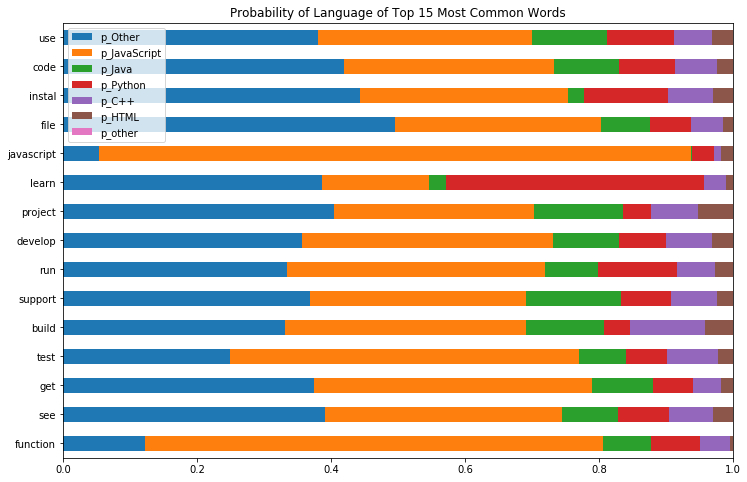

In [33]:
lang_prob = top_words[["all"]].copy()
for lang in top_words.drop(columns="all"):
    lang_prob[f"p_{lang}"] = top_words[lang] / top_words["all"]

lang_prob["p_other"] = 1.0 - lang_prob.drop(columns="all").sum(axis=1)

lang_prob.sort_values(by="all").tail(15).drop(columns="all").plot.barh(
    stacked=True, figsize=(12, 8)
)
plt.title("Probability of Language of Top 15 Most Common Words")
plt.show()

Unsurprisingly, the most common words are representatively spread out among the categories

#### Word Cloud

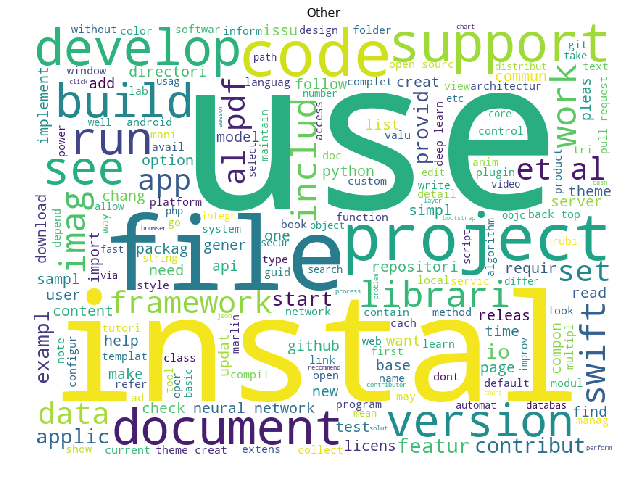

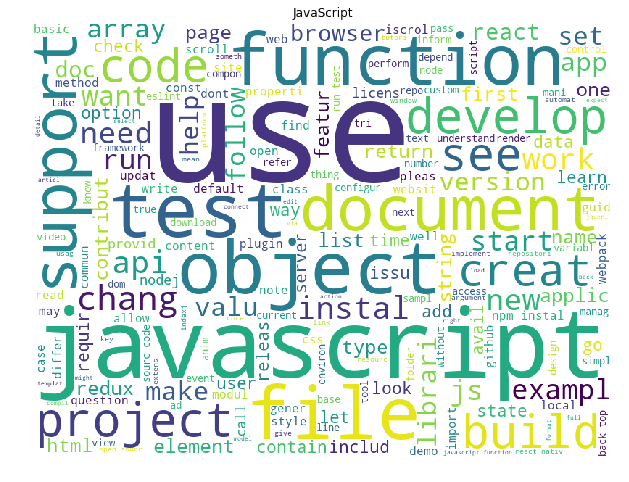

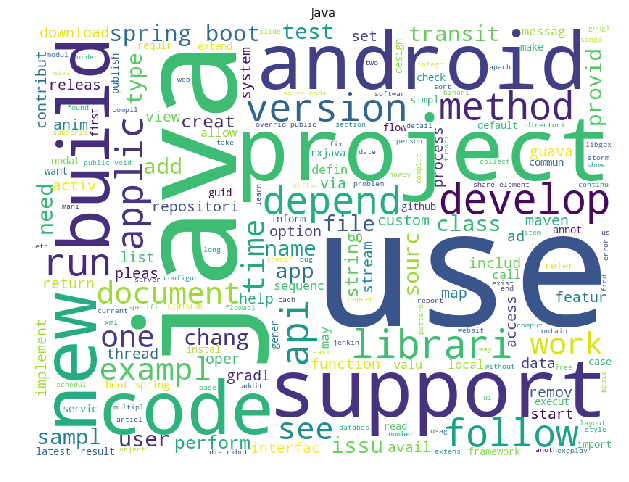

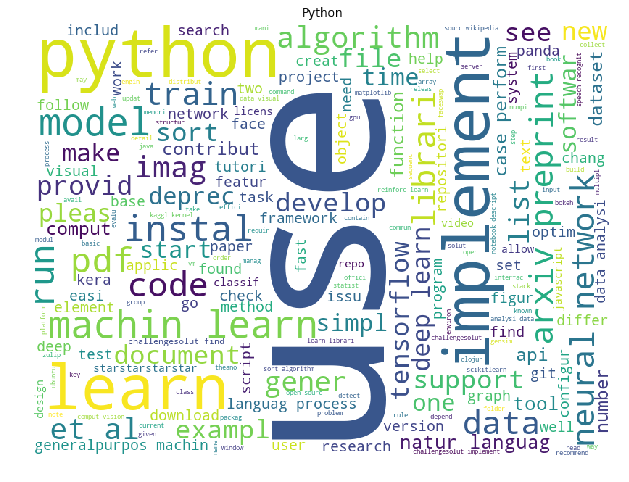

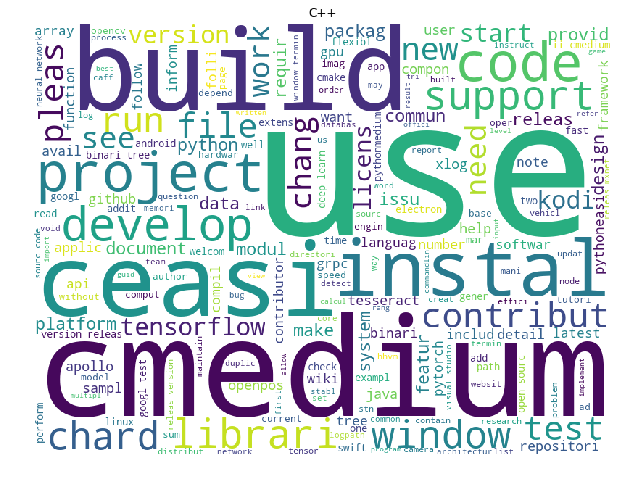

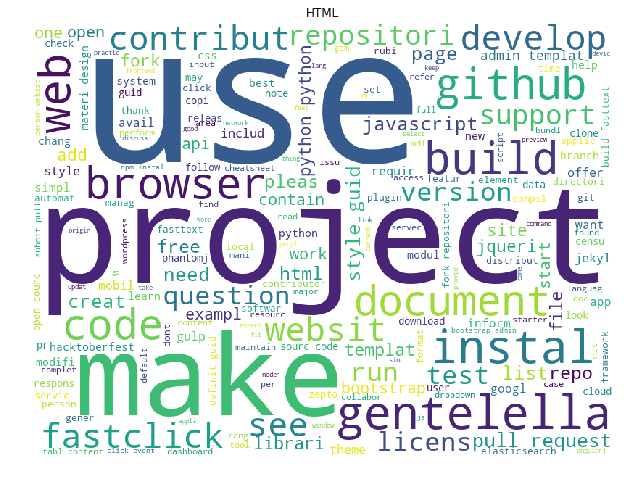

In [34]:
for lang, words in words_by_lang.items():
    plt.figure(figsize=(12, 8))
    cloud = WordCloud(
        background_color="white", height=600, width=800
    ).generate(words)
    plt.title(lang)
    plt.axis("off")
    plt.imshow(cloud)

**Conclusions**

"project", "use' are common words among the languages, but other than these, the most cmmon words among the languages are different.

### Bigrams

**Most common bigrams and bar plot**

Other
(et, al)             165
(al, pdf)            165
(neural, network)    106
(open, sourc)         89
(theme, creat)        85
dtype: int64


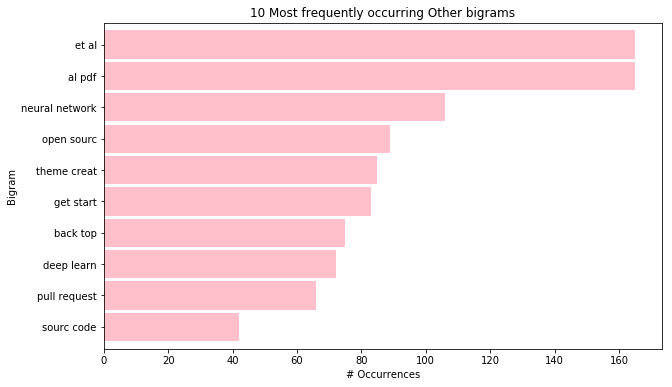

JavaScript
(get, start)     102
(npm, instal)     81
(back, top)       60
(run, test)       52
(sourc, code)     52
dtype: int64


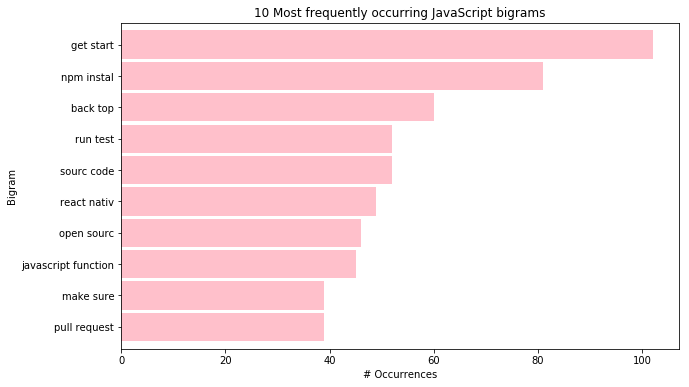

Java
(spring, boot)       52
(boot, spring)       24
(overrid, public)    23
(public, void)       21
(sourc, code)        19
dtype: int64


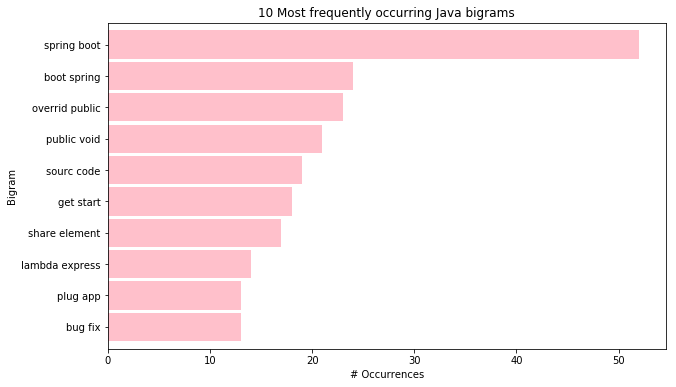

Python
(machin, learn)      112
(arxiv, preprint)     80
(neural, network)     79
(et, al)              65
(deep, learn)         45
dtype: int64


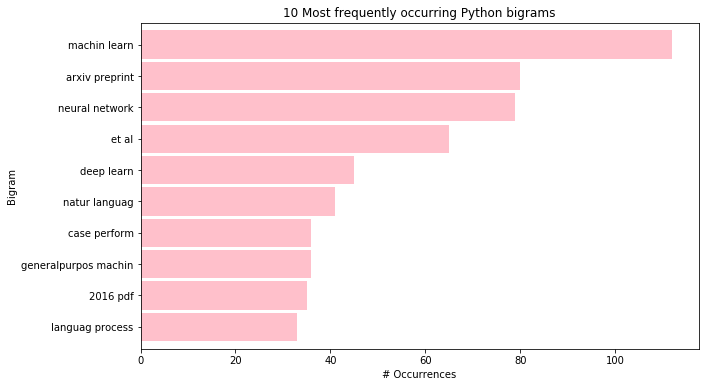

C++
(binari, tree)    17
(deep, learn)     16
(googl, test)     16
(ii, cmedium)     14
(open, sourc)     14
dtype: int64


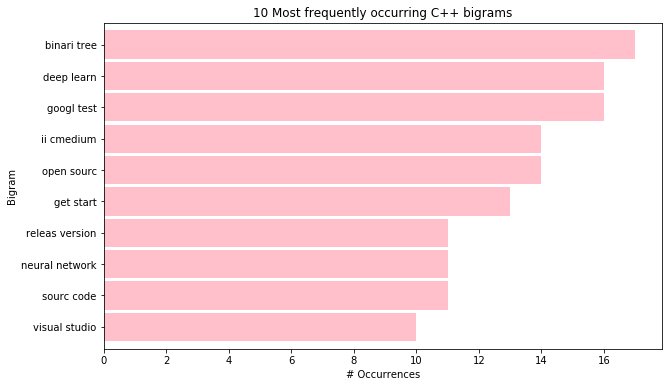

HTML
(pull, request)     16
(style, guid)       15
(python, python)    11
(admin, templat)    11
(materi, design)     8
dtype: int64


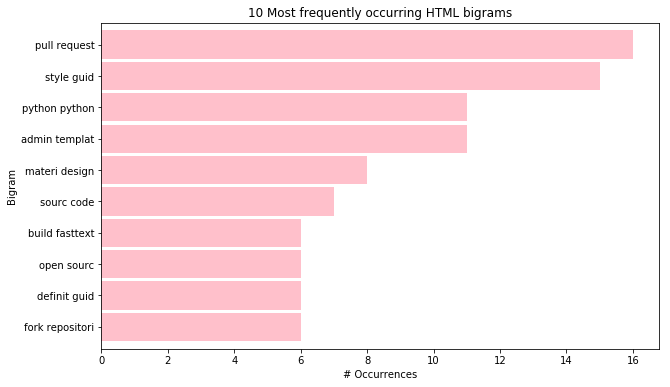

In [35]:
for lang, words in words_by_lang.items():
    bigrams = pd.Series(nltk.ngrams(words.split(), 2)).value_counts()
    print(f"{lang}\n{bigrams.head()}")

    # Bar plot the bigrams
    bigrams.sort_values().tail(10).plot.barh(
        color="pink", width=0.9, figsize=(10, 6)
    )

    plt.title(f"10 Most frequently occurring {lang} bigrams")
    plt.ylabel("Bigram")
    plt.xlabel("# Occurrences")

    # make the labels pretty
    ticks, _ = plt.yticks()
    labels = (
        bigrams.sort_values()
        .tail(10)
        .reset_index()["index"]
        .apply(lambda t: " ".join(t))
    )
    _ = plt.yticks(ticks, labels)
    plt.show()

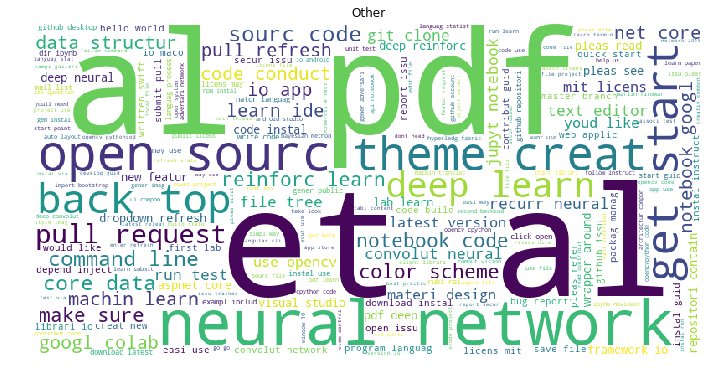

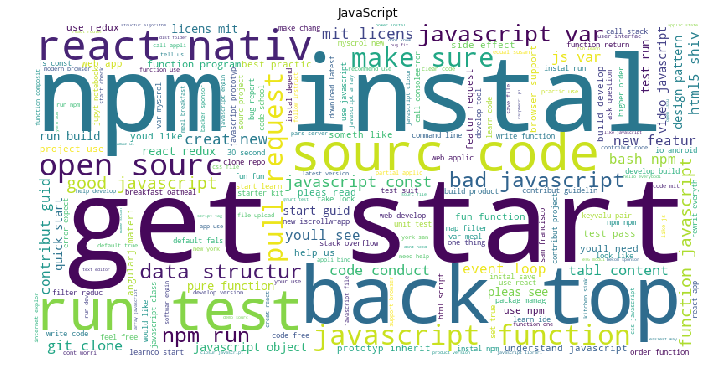

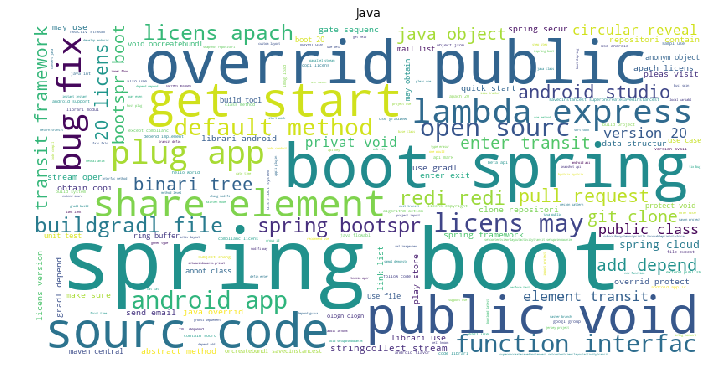

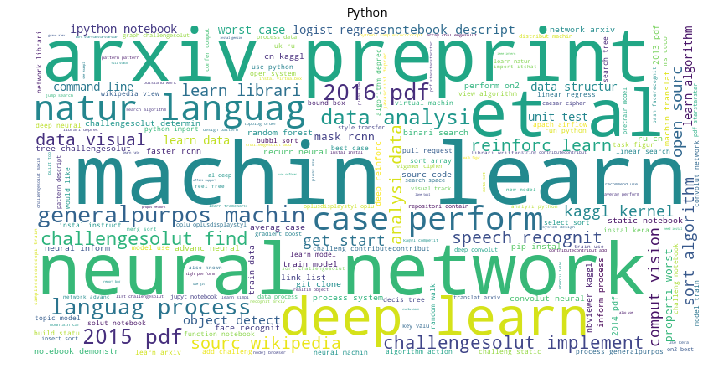

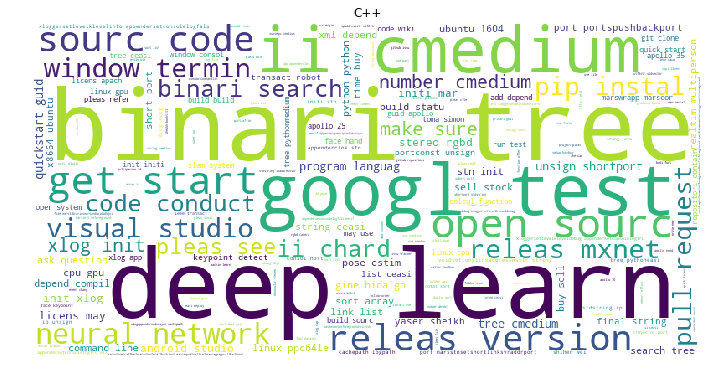

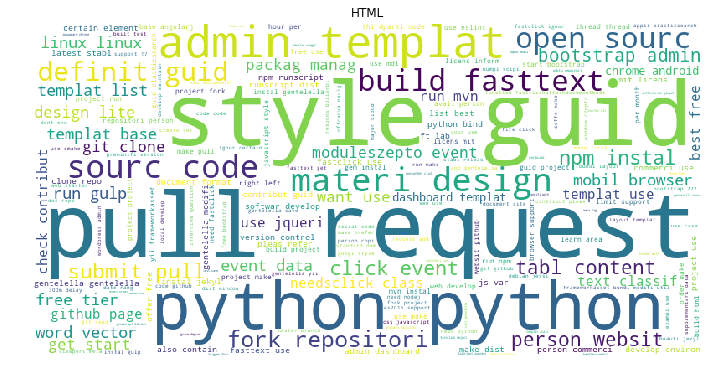

In [36]:
for lang, words in words_by_lang.items():
    bigrams = pd.Series(nltk.ngrams(words.split(), 2)).value_counts()

    # word cloud
    data = {" ".join(k): v for k, v in bigrams.to_dict().items()}
    img = WordCloud(
        background_color="white", width=800, height=400
    ).generate_from_frequencies(data)
    plt.figure(figsize=(12, 8))
    plt.axis("off")
    plt.title(lang)
    plt.imshow(img)

**Conclusions**

There is overlap among the languages as to the most common bigrams. The brigrams may not be that helpful after all.

### Trigram

Other
(et, al, pdf)                  160
(notebook, googl, colab)        27
(convolut, neural, network)     24
(recurr, neural, network)       21
(deep, neural, network)         18
dtype: int64


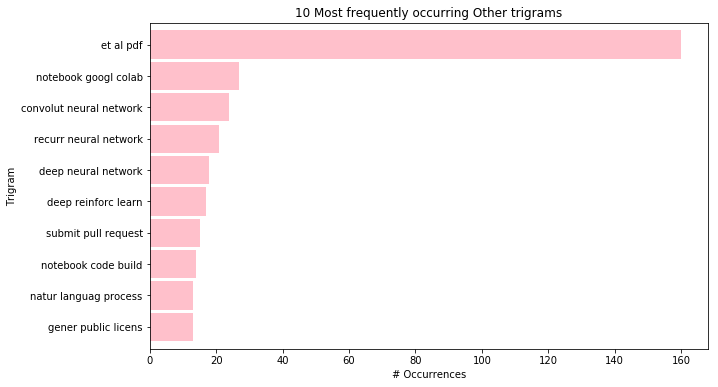

JavaScript
(bash, npm, instal)             15
(good, javascript, function)    14
(myscrol, new, iscrollwrapp)    14
(get, start, guid)              13
(fun, fun, function)            13
dtype: int64


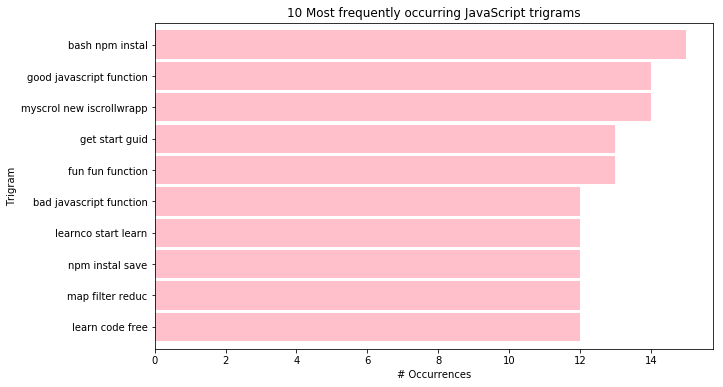

Java
(spring, boot, spring)       20
(overrid, public, void)      20
(boot, spring, boot)         14
(spring, bootspr, boot)       9
(share, element, transit)     8
dtype: int64


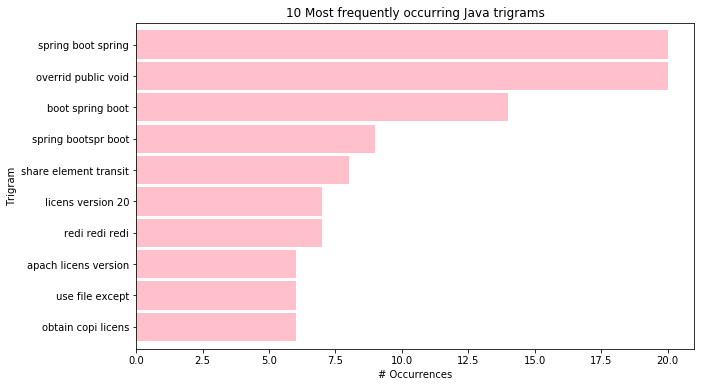

Python
(generalpurpos, machin, learn)    34
(natur, languag, process)         33
(data, analysi, data)             19
(analysi, data, visual)           18
(properti, worst, case)           12
dtype: int64


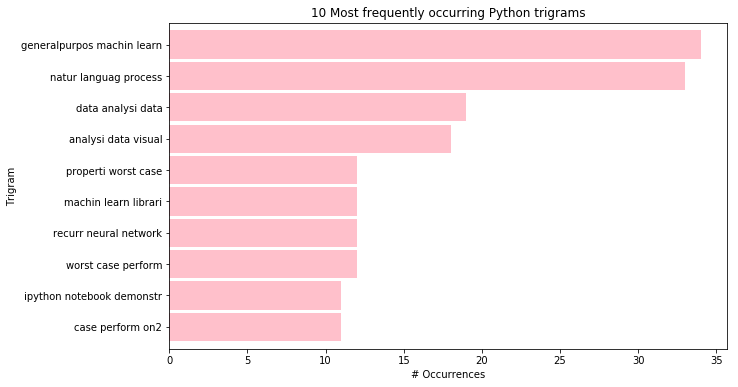

C++
(buy, sell, stock)                6
(time, buy, sell)                 6
(portconst, unsign, shortport)    6
(xml, depend, compil)             6
(xlog, init, xlog)                5
dtype: int64


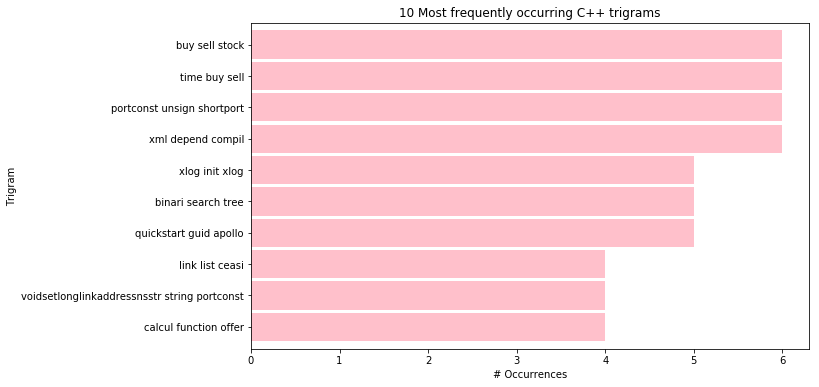

HTML
(python, python, python)       7
(submit, pull, request)        5
(materi, design, lite)         4
(bootstrap, admin, templat)    4
(moduleszepto, event, data)    4
dtype: int64


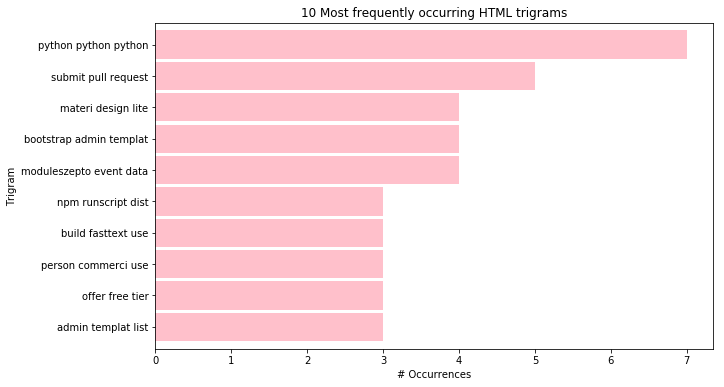

In [37]:
for lang, words in words_by_lang.items():
    trigrams = pd.Series(nltk.ngrams(words.split(), 3)).value_counts()
    print(f"{lang}\n{trigrams.head()}")

    # Bar plot the trigrams
    trigrams.sort_values().tail(10).plot.barh(
        color="pink", width=0.9, figsize=(10, 6)
    )

    plt.title(f"10 Most frequently occurring {lang} trigrams")
    plt.ylabel("Trigram")
    plt.xlabel("# Occurrences")

    # make the labels pretty
    ticks, _ = plt.yticks()
    labels = (
        trigrams.sort_values()
        .tail(10)
        .reset_index()["index"]
        .apply(lambda t: " ".join(t))
    )
    _ = plt.yticks(ticks, labels)
    plt.show()

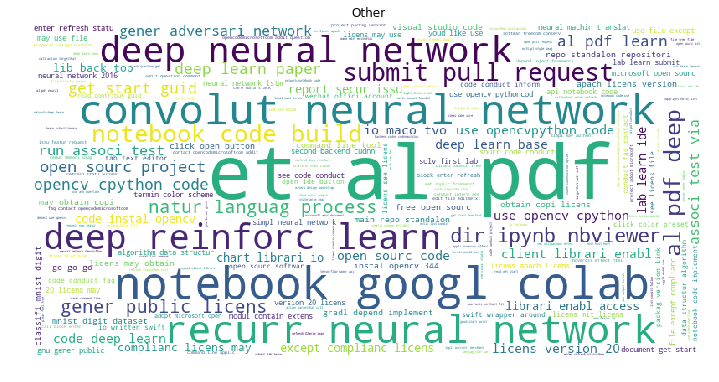

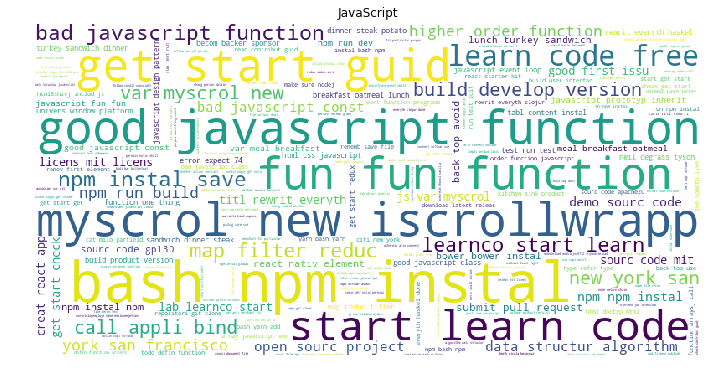

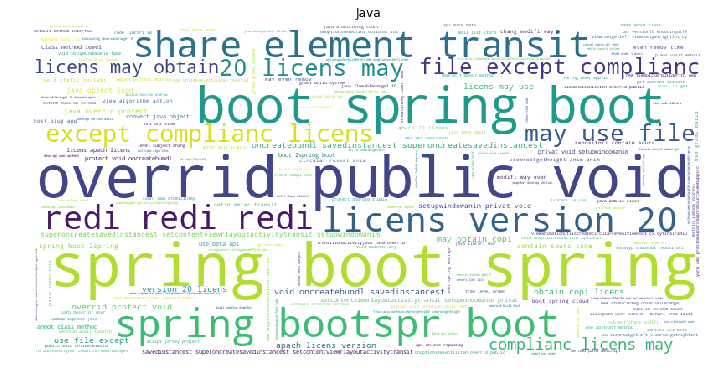

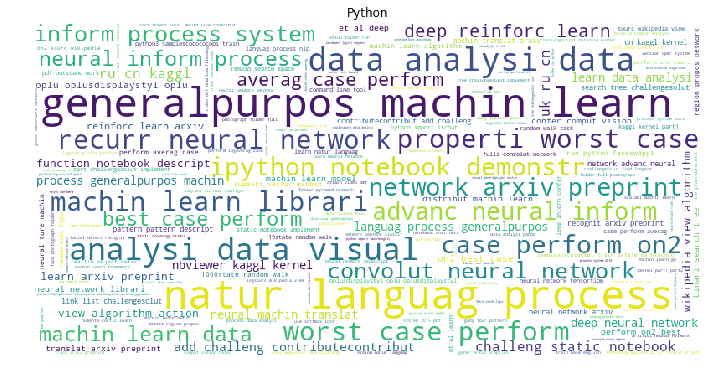

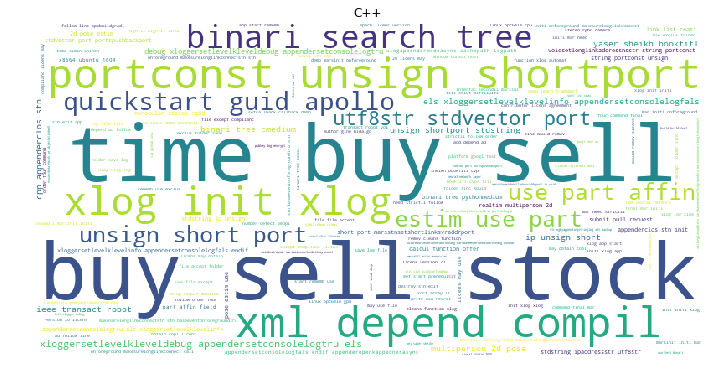

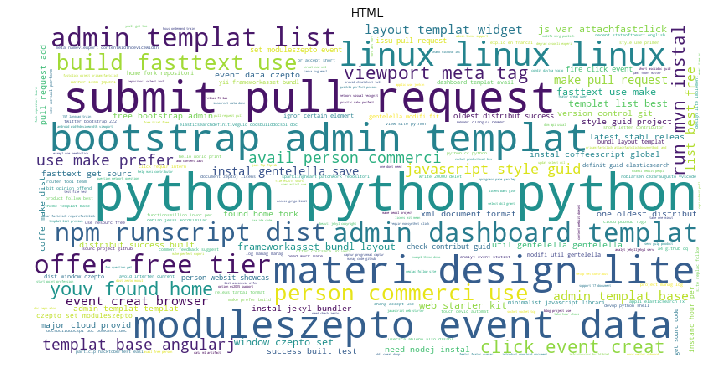

In [38]:
for lang, words in words_by_lang.items():
    trigrams = pd.Series(nltk.ngrams(words.split(), 3)).value_counts()

    # word cloud
    data = {" ".join(k): v for k, v in trigrams.to_dict().items()}
    img = WordCloud(
        background_color="white", width=800, height=400
    ).generate_from_frequencies(data)
    plt.figure(figsize=(12, 8))
    plt.axis("off")
    plt.title(lang)
    plt.imshow(img)

**Conclusion**


While there is less overlap of the most common trigrams than bigrams, these appear to be mostly junk or unique to a specific repo. 

### Summarize Conclusions

## Modeling <a name="modeling"></a>

In [39]:
def confmatrix(y_actual, y_pred):
    df = pd.DataFrame(dict(actual=y_actual, predicted=y_pred))
    return pd.crosstab(df.predicted, df.actual)

### Train test split

# Experiment: exclude those repos not in the top 5

In [40]:
print("before removal", len(df))
df = df[df.lang_grouped.isin(top_five)]
print("after removal", len(df))

before removal 781
after removal 490


In [41]:
df.lang_grouped.value_counts()

JavaScript    218
Java          116
Python         76
C++            44
HTML           36
Name: lang_grouped, dtype: int64

**Clean gives better results than lemmatized or stemmed**

In [42]:
# X_train, X_test, y_train, y_test = train_test_split(
#     df.lemmatized, df.lang_grouped, stratify=df.lang_grouped, test_size=0.2, random_state=123
# )

# X_train, X_test, y_train, y_test = train_test_split(
#     df.stemmed, df.lang_grouped, stratify=df.lang_grouped, test_size=0.2, random_state=123
# )

X_train, X_test, y_train, y_test = train_test_split(
    df.clean, df.lang_grouped, stratify=df.lang_grouped, test_size=0.2, random_state=123
)

In [43]:
X_train.shape

(392,)

In [44]:
X_train.head()

253    phantomjs scriptable headless webkit phantomjs...
273    angular webpack starter angular starter kit fe...
878    magicmirror2 open source modular smart mirror ...
494    pockethub repository contains source code pock...
240    using conditionals multiple files js know use ...
Name: clean, dtype: object

In [45]:
type(X_train)

pandas.core.series.Series

### For ALL Words

### Calculate TF-IDF for each word

In [46]:
tfidf = TfidfVectorizer()
train_tfidf = tfidf.fit_transform(X_train)
df_tfidf = pd.DataFrame(train_tfidf.todense(), columns=tfidf.get_feature_names())

test_tfidf = tfidf.transform(X_test)

In [47]:
train_tfidf.shape

(392, 17553)

**Words with highest tf-idf**

In [48]:
df_tfidf.max().sort_values(ascending=False).head(10)

phonegap          0.882740
gekko             0.872344
redux             0.866825
edx               0.866220
pixijs            0.852612
v8                0.844826
deeplearning4j    0.835843
libgdx            0.828198
simplified        0.827887
brackets          0.826353
dtype: float64

**Words with lowest tf-idf**

In [49]:
df_tfidf.max().sort_values(ascending=False).tail(10)

weaksets      0.005248
encoded       0.005248
weakmaps      0.005248
emulating     0.005248
vail          0.005248
intervals     0.004959
preventing    0.004912
joseph        0.004912
rob           0.004912
grasp         0.004912
dtype: float64

**What does the distribution look like?**

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


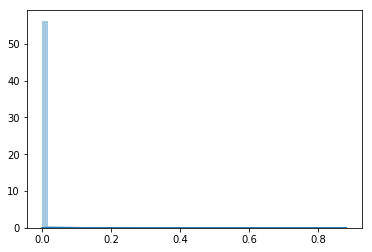

In [50]:
sns.distplot(train_tfidf.todense().flatten())

### KNN

In [51]:
def knnmodel(X_train, X_test, y_train, y_test, **kwargs):
    ks = range(1, 15)
    sse = []
    for k in ks:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X_train)

        # inertia: Sum of squared distances of samples to their closest cluster center.
        sse.append(kmeans.inertia_)

    print(pd.DataFrame(dict(k=ks, sse=sse)))

    plt.plot(ks, sse, "bx-")
    plt.xlabel("k")
    plt.ylabel("SSE")
    plt.title("The Elbow Method showing the optimal k")
    plt.show()
    
    knn = KNeighborsClassifier(**kwargs)
    knn.fit(X_train, y_train)
    y_pred_train = knn.predict(X_train)
    y_pred_proba_train = knn.predict_proba(X_train)
    
    print("TRAIN")
    print()
    print(
        "Accuracy of KNN classifier on training set: {:.2f}".format(
        knn.score(X_train, y_train)
        )
    )
    print()
    confmatrix(y_train, y_pred_train)
    print()
    print(classification_report(y_train, y_pred_train))
    
    y_pred_test = knn.predict(X_test)
    y_pred_proba_test = knn.predict_proba(X_test)
    
    print("-" * 20)
    print()
    print("TEST")
    print()
    print(
        "Accuracy of KNN classifier on training set: {:.2f}".format(
        knn.score(X_test, y_test)
        )
    )
    print()
    confmatrix(y_test, y_pred_test)
    print()
    print(classification_report(y_test, y_pred_test))
    
    k_range = range(1, 20)
    scores = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        scores.append(knn.score(X_test, y_test))
    plt.figure()
    plt.xlabel("k")
    plt.ylabel("accuracy")
    plt.scatter(k_range, scores)
    # plt.xticks([0,5,10,15,20])

     k         sse
0    1  382.765728
1    2  380.744397
2    3  378.948560
3    4  377.035502
4    5  374.135711
5    6  373.404080
6    7  371.826954
7    8  370.206561
8    9  369.773891
9   10  367.501244
10  11  365.888552
11  12  364.790814
12  13  361.814664
13  14  361.117104


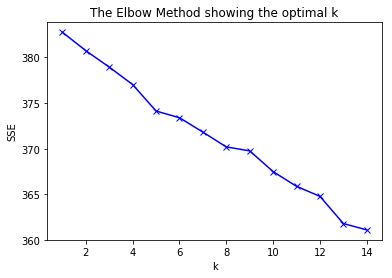

TRAIN

Accuracy of KNN classifier on training set: 0.77


              precision    recall  f1-score   support

         C++       0.81      0.37      0.51        35
        HTML       0.56      0.31      0.40        29
        Java       0.75      0.85      0.80        93
  JavaScript       0.78      0.91      0.84       174
      Python       0.77      0.66      0.71        61

   micro avg       0.77      0.77      0.77       392
   macro avg       0.74      0.62      0.65       392
weighted avg       0.76      0.77      0.75       392

--------------------

TEST

Accuracy of KNN classifier on training set: 0.69


              precision    recall  f1-score   support

         C++       0.14      0.11      0.12         9
        HTML       0.60      0.43      0.50         7
        Java       0.57      0.70      0.63        23
  JavaScript       0.86      0.84      0.85        44
      Python       0.73      0.73      0.73        15

   micro avg       0.69      0.69      0.69     

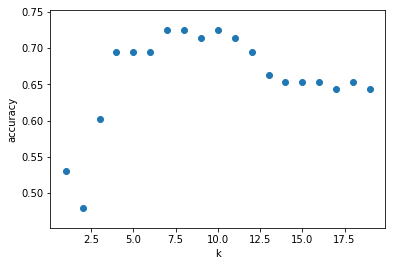

In [52]:
knnmodel(train_tfidf, test_tfidf, y_train, y_test,
    n_neighbors=6, weights="uniform")

### Naive Bayes Model

In [53]:
def nbmodel(X_train, X_test, y_train, y_test, **kwargs):
    gnb = GaussianNB(**kwargs)
    gnb.fit(X_train, y_train)
    
    print("TRAIN")
    print()
    y_pred_train = gnb.predict(X_train)
    print(
        "Accuracy of GNB classifier on training set: {:.2f}".format(
            gnb.score(X_train, y_train)
        )
    )
    print()
    print(confmatrix(y_train, y_pred_train))
    print()
    print(classification_report(y_train, y_pred_train))
    
    print("-" * 20)
    print()
    print("TEST")
    print()
    y_pred_test = gnb.predict(X_test)
    print(
        "Accuracy of GNB classifier on training set: {:.2f}".format(
            gnb.score(X_test, y_test)
        )
    )
    print()
    print(confmatrix(y_test, y_pred_test))
    print()
    print(classification_report(y_test, y_pred_test))

In [54]:
nbmodel(train_tfidf.todense(), test_tfidf.todense(), y_train, y_test)

TRAIN

Accuracy of GNB classifier on training set: 0.99

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          35     0     1           1       0
HTML          0    29     0           0       0
Java          0     0    92           0       0
JavaScript    0     0     0         172       0
Python        0     0     0           1      61

              precision    recall  f1-score   support

         C++       0.95      1.00      0.97        35
        HTML       1.00      1.00      1.00        29
        Java       1.00      0.99      0.99        93
  JavaScript       1.00      0.99      0.99       174
      Python       0.98      1.00      0.99        61

   micro avg       0.99      0.99      0.99       392
   macro avg       0.99      1.00      0.99       392
weighted avg       0.99      0.99      0.99       392

--------------------

TEST

Accuracy of GNB classifier on training set: 0.62

actual      C++  HTML  Java  JavaScript

# BEST MODEL USING TOP 500 FORKED REPOS AND LIMITING TO TOP 5 LANGUAGES!!!

### Logistic Regression

In [55]:
def lrmodel(X_train, X_test, y_train, y_test, **kwargs):
    lm = LogisticRegression(**kwargs).fit(X_train, y_train)
    
    print("TRAIN")
    print()
    y_pred_train = lm.predict(X_train)
    print(
        "Accuracy of lm classifier on training set: {:.2f}".format(
            accuracy_score(y_train, y_pred_train)
        )
    )
    print()
    print(confmatrix(y_train, y_pred_train))
    print()
    print(classification_report(y_train, y_pred_train))
    
    print("-" * 20)
    print()
    print("TEST")
    print()
    y_pred_test = lm.predict(X_test)
    print(
        "Accuracy of lm classifier on training set: {:.2f}".format(
            accuracy_score(y_test, y_pred_test)
        )
    )
    print()
    print(confmatrix(y_test, y_pred_test))
    print()
    print(classification_report(y_test, y_pred_test))

In [56]:
lrmodel(train_tfidf, test_tfidf, y_train, y_test, random_state=123,
    solver="newton-cg",
    multi_class="multinomial",
    class_weight="balanced")

TRAIN

Accuracy of lm classifier on training set: 0.99

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          35     0     0           0       0
HTML          0    29     0           0       0
Java          0     0    93           2       0
JavaScript    0     0     0         172       0
Python        0     0     0           0      61

              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        35
        HTML       1.00      1.00      1.00        29
        Java       0.98      1.00      0.99        93
  JavaScript       1.00      0.99      0.99       174
      Python       1.00      1.00      1.00        61

   micro avg       0.99      0.99      0.99       392
   macro avg       1.00      1.00      1.00       392
weighted avg       1.00      0.99      0.99       392

--------------------

TEST

Accuracy of lm classifier on training set: 0.70

actual      C++  HTML  Java  JavaScript  

### Decision Tree

In [57]:
clf = DecisionTreeClassifier(
    criterion="entropy", max_depth=20, random_state=123, class_weight="balanced"
)

In [58]:
clf.fit(train_tfidf, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=20, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

In [59]:
y_pred = clf.predict(train_tfidf)
y_pred[0:5]

array(['HTML', 'Python', 'JavaScript', 'Java', 'JavaScript'], dtype=object)

In [60]:
y_pred_proba = clf.predict_proba(train_tfidf)
# y_pred_proba

### Computing the accuracy of our model

In [61]:
print(
    "Accuracy of Decision Tree classifier on training set: {:.2f}".format(
        clf.score(train_tfidf, y_train)
    )
)

Accuracy of Decision Tree classifier on training set: 0.90


In [62]:
confmatrix(y_train, y_pred)

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          35     0     0           0       0
HTML          0    27     0           0       0
Java          0     0    78           0       0
JavaScript    0     0     0         150       0
Python        0     2    15          24      61

In [63]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        35
        HTML       1.00      0.93      0.96        29
        Java       1.00      0.84      0.91        93
  JavaScript       1.00      0.86      0.93       174
      Python       0.60      1.00      0.75        61

   micro avg       0.90      0.90      0.90       392
   macro avg       0.92      0.93      0.91       392
weighted avg       0.94      0.90      0.90       392



In [64]:
print(
    "Accuracy of Decision Tree classifier on test set: {:.2f}".format(
        clf.score(test_tfidf, y_test)
    )
)

Accuracy of Decision Tree classifier on test set: 0.48


### Random Forest

In [65]:
def rfmodel(X_train, X_test, y_train, y_test, **kwargs):
    clf = RandomForestClassifier(**kwargs).fit(X_train, y_train)
    
#     print("Feature Importances:")
#     print(clf.feature_importances_)
    print()
    print("TRAIN")
    print()
    y_pred_train = clf.predict(X_train)
    print(
        "Accuracy of clf classifier on training set: {:.2f}".format(
            accuracy_score(y_train, y_pred_train)
        )
    )
    print()
    print(confmatrix(y_train, y_pred_train))
    print()
    print(classification_report(y_train, y_pred_train))
    
    print("-" * 20)
    print()
    print("TEST")
    print()
    y_pred_test = clf.predict(X_test)
    print(
        "Accuracy of clf classifier on training set: {:.2f}".format(
            accuracy_score(y_test, y_pred_test)
        )
    )
    print()
    print(confmatrix(y_test, y_pred_test))
    print()
    print(classification_report(y_test, y_pred_test))

In [66]:
rfmodel(train_tfidf, test_tfidf, y_train, y_test,
    n_estimators=100,
    max_depth=10,
    random_state=123,
    class_weight="balanced",
)


TRAIN

Accuracy of clf classifier on training set: 0.92

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          30     0     0           0       0
HTML          0    26     0           0       0
Java          4     3    93          15       7
JavaScript    1     0     0         158       1
Python        0     0     0           1      53

              precision    recall  f1-score   support

         C++       1.00      0.86      0.92        35
        HTML       1.00      0.90      0.95        29
        Java       0.76      1.00      0.87        93
  JavaScript       0.99      0.91      0.95       174
      Python       0.98      0.87      0.92        61

   micro avg       0.92      0.92      0.92       392
   macro avg       0.95      0.91      0.92       392
weighted avg       0.94      0.92      0.92       392

--------------------

TEST

Accuracy of clf classifier on training set: 0.66

actual      C++  HTML  Java  JavaScrip

### Excluding frequent words

### Calculate TF-IDF for each word

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_df=0.05)
train_tfidf = tfidf.fit_transform(X_train)
df_tfidf = pd.DataFrame(train_tfidf.todense(), columns=tfidf.get_feature_names())

test_tfidf = tfidf.transform(X_test)

In [68]:
train_tfidf.shape

(392, 17070)

**Words with highest tf-idf**

In [69]:
df_tfidf.max().sort_values(ascending=False).head(10)

hadoop        1.000000
druid         1.000000
moved         1.000000
tornado       1.000000
simplified    1.000000
jennic        1.000000
zookeeper     1.000000
phonegap      0.946806
edx           0.938528
redux         0.925351
dtype: float64

**Words with lowest tf-idf**

In [70]:
df_tfidf.max().sort_values(ascending=False).tail(10)

978longest        0.005331
979distribute     0.005331
310minimum        0.005331
97interleaving    0.005331
980unique         0.005331
981time           0.005331
30substring       0.005331
983minimum        0.005331
984string         0.005331
climbing          0.005331
dtype: float64

**What does the distribution look like?**

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


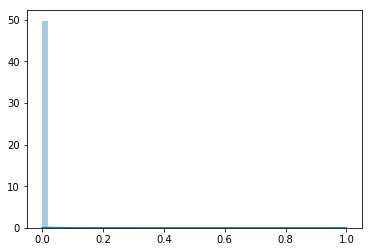

In [71]:
sns.distplot(train_tfidf.todense().flatten())

In [72]:
lrmodel(train_tfidf, test_tfidf, y_train, y_test, random_state=123,
    solver="newton-cg",
    multi_class="multinomial",
    class_weight="balanced")

TRAIN

Accuracy of lm classifier on training set: 0.99

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          35     0     0           0       0
HTML          0    29     0           1       0
Java          0     0    93           1       0
JavaScript    0     0     0         172       0
Python        0     0     0           0      61

              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        35
        HTML       0.97      1.00      0.98        29
        Java       0.99      1.00      0.99        93
  JavaScript       1.00      0.99      0.99       174
      Python       1.00      1.00      1.00        61

   micro avg       0.99      0.99      0.99       392
   macro avg       0.99      1.00      0.99       392
weighted avg       1.00      0.99      0.99       392

--------------------

TEST

Accuracy of lm classifier on training set: 0.60

actual      C++  HTML  Java  JavaScript  

In [73]:
rfmodel(train_tfidf, test_tfidf, y_train, y_test,
    n_estimators=1000,
    min_samples_leaf=3,
    max_depth=20,
    random_state=123,
    class_weight="balanced",
)


TRAIN

Accuracy of clf classifier on training set: 0.85

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          28     0     0           0       0
HTML          0    22     0           5       0
Java          5     5    93          28      11
JavaScript    1     1     0         141       0
Python        1     1     0           0      50

              precision    recall  f1-score   support

         C++       1.00      0.80      0.89        35
        HTML       0.81      0.76      0.79        29
        Java       0.65      1.00      0.79        93
  JavaScript       0.99      0.81      0.89       174
      Python       0.96      0.82      0.88        61

   micro avg       0.85      0.85      0.85       392
   macro avg       0.88      0.84      0.85       392
weighted avg       0.89      0.85      0.86       392

--------------------

TEST

Accuracy of clf classifier on training set: 0.60

actual      C++  HTML  Java  JavaScrip

### Excluding least frequent words

### Calculate TF-IDF for each word

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=0.01)
train_tfidf = tfidf.fit_transform(X_train)
df_tfidf = pd.DataFrame(train_tfidf.todense(), columns=tfidf.get_feature_names())

test_tfidf = tfidf.transform(X_test)

In [75]:
train_tfidf.shape

(392, 2533)

**Words with highest tf-idf**

In [76]:
df_tfidf.max().sort_values(ascending=False).head(10)

redis       0.927292
redux       0.887604
api         0.873751
electron    0.867214
2015        0.863951
flux        0.863100
python3     0.859480
brackets    0.858845
figure      0.856797
atom        0.848905
dtype: float64

**Words with lowest tf-idf**

In [77]:
df_tfidf.max().sort_values(ascending=False).tail(10)

telling        0.028492
accordingly    0.028492
keeps          0.028264
accomplish     0.027524
said           0.026705
mutable        0.024082
combine        0.023329
smallest       0.023268
absolute       0.018050
concept        0.011975
dtype: float64

**What does the distribution look like?**

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


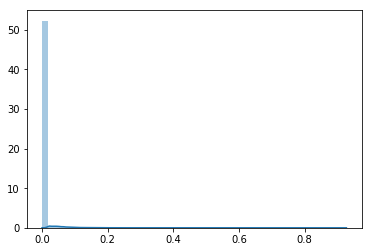

In [78]:
sns.distplot(train_tfidf.todense().flatten())

In [79]:
lrmodel(train_tfidf, test_tfidf, y_train, y_test, random_state=123,
    solver="newton-cg",
    multi_class="multinomial",
    class_weight="balanced")

TRAIN

Accuracy of lm classifier on training set: 0.98

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          34     0     1           0       0
HTML          0    29     0           2       0
Java          1     0    92           3       0
JavaScript    0     0     0         169       0
Python        0     0     0           0      61

              precision    recall  f1-score   support

         C++       0.97      0.97      0.97        35
        HTML       0.94      1.00      0.97        29
        Java       0.96      0.99      0.97        93
  JavaScript       1.00      0.97      0.99       174
      Python       1.00      1.00      1.00        61

   micro avg       0.98      0.98      0.98       392
   macro avg       0.97      0.99      0.98       392
weighted avg       0.98      0.98      0.98       392

--------------------

TEST

Accuracy of lm classifier on training set: 0.68

actual      C++  HTML  Java  JavaScript  

In [80]:
rfmodel(train_tfidf, test_tfidf, y_train, y_test,
    n_estimators=1000,
    min_samples_leaf=3,
    max_depth=20,
    random_state=123,
    class_weight="balanced",
)


TRAIN

Accuracy of clf classifier on training set: 0.95

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          34     0     0           0       0
HTML          0    27     0           0       0
Java          1     1    93          15       1
JavaScript    0     0     0         158       0
Python        0     1     0           1      60

              precision    recall  f1-score   support

         C++       1.00      0.97      0.99        35
        HTML       1.00      0.93      0.96        29
        Java       0.84      1.00      0.91        93
  JavaScript       1.00      0.91      0.95       174
      Python       0.97      0.98      0.98        61

   micro avg       0.95      0.95      0.95       392
   macro avg       0.96      0.96      0.96       392
weighted avg       0.96      0.95      0.95       392

--------------------

TEST

Accuracy of clf classifier on training set: 0.69

actual      C++  HTML  Java  JavaScrip

### Excluding most and least frequent words

### Calculate TF-IDF for each word

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=0.01, max_df=0.05)
train_tfidf = tfidf.fit_transform(X_train)
df_tfidf = pd.DataFrame(train_tfidf.todense(), columns=tfidf.get_feature_names())

test_tfidf = tfidf.transform(X_test)

In [82]:
train_tfidf.shape

(392, 2050)

**Words with highest tf-idf**

In [83]:
df_tfidf.max().sort_values(ascending=False).head(10)

renamed       1.0
python3       1.0
hadoop        1.0
promise       1.0
progress      1.0
2015          1.0
moved         1.0
express       1.0
associated    1.0
simplified    1.0
dtype: float64

**Words with lowest tf-idf**

In [84]:
df_tfidf.max().sort_values(ascending=False).tail(10)

equality       0.040742
keeps          0.039900
digits         0.039694
declaration    0.039358
31             0.038187
mutable        0.035277
smallest       0.031383
combine        0.030910
absolute       0.019847
concept        0.016919
dtype: float64

**What does the distribution look like?**

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


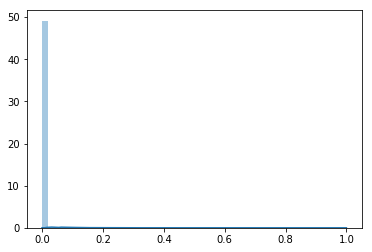

In [85]:
sns.distplot(train_tfidf.todense().flatten())

In [86]:
lrmodel(train_tfidf, test_tfidf, y_train, y_test, random_state=123,
    solver="newton-cg",
    multi_class="multinomial",
    class_weight="balanced")

TRAIN

Accuracy of lm classifier on training set: 0.95

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          34     0     0           0       0
HTML          0    29     1           3       0
Java          0     0    86           3       0
JavaScript    1     0     6         166       2
Python        0     0     0           2      59

              precision    recall  f1-score   support

         C++       1.00      0.97      0.99        35
        HTML       0.88      1.00      0.94        29
        Java       0.97      0.92      0.95        93
  JavaScript       0.95      0.95      0.95       174
      Python       0.97      0.97      0.97        61

   micro avg       0.95      0.95      0.95       392
   macro avg       0.95      0.96      0.96       392
weighted avg       0.96      0.95      0.95       392

--------------------

TEST

Accuracy of lm classifier on training set: 0.58

actual      C++  HTML  Java  JavaScript  

In [87]:
rfmodel(train_tfidf, test_tfidf, y_train, y_test,
    n_estimators=100,
    max_depth=20,
    random_state=123,
    class_weight="balanced",
)


TRAIN

Accuracy of clf classifier on training set: 0.92

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          30     0     0           0       0
HTML          0    26     0           0       0
Java          0     1    82           0       3
JavaScript    5     2    11         174      10
Python        0     0     0           0      48

              precision    recall  f1-score   support

         C++       1.00      0.86      0.92        35
        HTML       1.00      0.90      0.95        29
        Java       0.95      0.88      0.92        93
  JavaScript       0.86      1.00      0.93       174
      Python       1.00      0.79      0.88        61

   micro avg       0.92      0.92      0.92       392
   macro avg       0.96      0.88      0.92       392
weighted avg       0.93      0.92      0.92       392

--------------------

TEST

Accuracy of clf classifier on training set: 0.59

actual      C++  HTML  Java  JavaScrip

**Conclusions**

Excluding the least common words gives me the best results on the test dataset. However, all the models that exclude the least or most frequent words do not perform as well as not excluding them. Thus, I don't think it's a good idea to exclude the most or least frequent words. 

### Using Bigrams as features

### TF-IDF

Top 100 did not work well

In [88]:
TOP_NBIGRAMS = 5_000
# top_nwords = top_words.sort_values(by="all", ascending=False).head(500)
# top_nwords.index.values

### Calculate TF-IDF for each word

In [89]:
tfidf = TfidfVectorizer(
    strip_accents="unicode", max_features=TOP_NBIGRAMS, ngram_range=(2, 2)
)
# tfidf = TfidfVectorizer(
#     strip_accents="unicode", ngram_range=(2, 2)
# )
train_tfidf = tfidf.fit_transform(X_train)
df_tfidf = pd.DataFrame(train_tfidf.todense(), columns=tfidf.get_feature_names())

test_tfidf = tfidf.transform(X_test)

In [90]:
train_tfidf.shape

(392, 5000)

In [91]:
test_tfidf.shape

(98, 5000)

In [92]:
df_tfidf.max().sort_values(ascending=False).head(10)

jack cui              1.0
github pages          1.0
spring bootweb        1.0
web server            1.0
starter kit           1.0
web applications      1.0
web app               1.0
machine learning      1.0
javascript library    1.0
code wiki             1.0
dtype: float64

In [93]:
df_tfidf.max().sort_values(ascending=False).tail(10)

new direction          0.017319
first paper            0.017319
networks natural       0.017319
ilya sutskever         0.017319
understanding deep     0.017319
generating image       0.017319
european conference    0.017319
pattern recognition    0.016201
filter javascript      0.011332
data neural            0.009196
dtype: float64

**What does the distribution look like?**

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


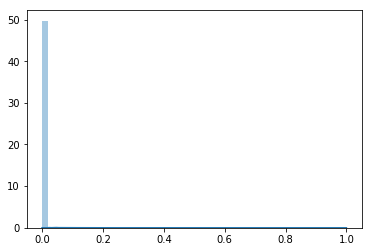

In [94]:
sns.distplot(train_tfidf.todense().flatten())

### Naive Bayes Model

In [95]:
nbmodel(train_tfidf.todense(), test_tfidf.todense(), y_train, y_test)

TRAIN

Accuracy of GNB classifier on training set: 0.92

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          34     0     1           2       1
HTML          1    29     7          13       7
Java          0     0    85           1       0
JavaScript    0     0     0         158       0
Python        0     0     0           0      53

              precision    recall  f1-score   support

         C++       0.89      0.97      0.93        35
        HTML       0.51      1.00      0.67        29
        Java       0.99      0.91      0.95        93
  JavaScript       1.00      0.91      0.95       174
      Python       1.00      0.87      0.93        61

   micro avg       0.92      0.92      0.92       392
   macro avg       0.88      0.93      0.89       392
weighted avg       0.95      0.92      0.93       392

--------------------

TEST

Accuracy of GNB classifier on training set: 0.51

actual      C++  HTML  Java  JavaScript

### Logistic Regression

In [96]:
lrmodel(train_tfidf, test_tfidf, y_train, y_test,
    random_state=123,
    solver="newton-cg",
    multi_class="multinomial",
    class_weight="balanced",
)

TRAIN

Accuracy of lm classifier on training set: 0.97

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          35     0     0           0       0
HTML          0    27     0           0       0
Java          0     0    88           0       0
JavaScript    0     2     5         173       5
Python        0     0     0           1      56

              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        35
        HTML       1.00      0.93      0.96        29
        Java       1.00      0.95      0.97        93
  JavaScript       0.94      0.99      0.96       174
      Python       0.98      0.92      0.95        61

   micro avg       0.97      0.97      0.97       392
   macro avg       0.98      0.96      0.97       392
weighted avg       0.97      0.97      0.97       392

--------------------

TEST

Accuracy of lm classifier on training set: 0.58

actual      C++  HTML  Java  JavaScript  

### Random Forest

In [97]:
rfmodel(train_tfidf, test_tfidf, y_train, y_test,
    n_estimators=100, max_depth=20, random_state=123, class_weight="balanced"
)


TRAIN

Accuracy of clf classifier on training set: 0.85

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          28     0     0           0       0
HTML          0    26     0           0       0
Java          7     3    90          31      13
JavaScript    0     0     3         143       2
Python        0     0     0           0      46

              precision    recall  f1-score   support

         C++       1.00      0.80      0.89        35
        HTML       1.00      0.90      0.95        29
        Java       0.62      0.97      0.76        93
  JavaScript       0.97      0.82      0.89       174
      Python       1.00      0.75      0.86        61

   micro avg       0.85      0.85      0.85       392
   macro avg       0.92      0.85      0.87       392
weighted avg       0.90      0.85      0.86       392

--------------------

TEST

Accuracy of clf classifier on training set: 0.48

actual      C++  HTML  Java  JavaScrip

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Bag of Words

In [98]:
vectorizer = CountVectorizer(max_features=750)
train_bow = vectorizer.fit_transform(X_train)
test_bow = vectorizer.transform(X_test)

df_bow = pd.DataFrame(train_bow.todense(), columns=vectorizer.get_feature_names())

In [99]:
train_bow.shape

(392, 750)

**Most common wordsf**

In [100]:
df_bow.sum().sort_values(ascending=False).head(10)

javascript    756
use           598
code          510
using         441
new           394
data          351
see           324
project       311
learning      290
install       283
dtype: int64

**Least common words**

In [101]:
df_bow.sum().sort_values(ascending=False).tail(10)

arguments     24
int           24
delete        24
uk            24
lot           24
foundation    24
variety       24
calls         24
interfaces    24
instance      24
dtype: int64

In [102]:
nbmodel(train_bow.todense(), test_bow.todense(), y_train, y_test)

TRAIN

Accuracy of GNB classifier on training set: 0.73

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          32     0    12          12      13
HTML          3    29    14          15       5
Java          0     0    67          21       7
JavaScript    0     0     0         121       0
Python        0     0     0           5      36

              precision    recall  f1-score   support

         C++       0.46      0.91      0.62        35
        HTML       0.44      1.00      0.61        29
        Java       0.71      0.72      0.71        93
  JavaScript       1.00      0.70      0.82       174
      Python       0.88      0.59      0.71        61

   micro avg       0.73      0.73      0.73       392
   macro avg       0.70      0.78      0.69       392
weighted avg       0.82      0.73      0.74       392

--------------------

TEST

Accuracy of GNB classifier on training set: 0.54

actual      C++  HTML  Java  JavaScript

In [103]:
lrmodel(train_bow, test_bow, y_train, y_test, random_state=123,
    solver="newton-cg",
    multi_class="multinomial",
    class_weight="balanced")

TRAIN

Accuracy of lm classifier on training set: 0.99

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          35     0     0           0       0
HTML          0    29     0           0       0
Java          0     0    93           2       0
JavaScript    0     0     0         172       0
Python        0     0     0           0      61

              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        35
        HTML       1.00      1.00      1.00        29
        Java       0.98      1.00      0.99        93
  JavaScript       1.00      0.99      0.99       174
      Python       1.00      1.00      1.00        61

   micro avg       0.99      0.99      0.99       392
   macro avg       1.00      1.00      1.00       392
weighted avg       1.00      0.99      0.99       392

--------------------

TEST

Accuracy of lm classifier on training set: 0.61

actual      C++  HTML  Java  JavaScript  

In [104]:
rfmodel(train_bow, test_bow, y_train, y_test,
    n_estimators=200, max_depth=10, random_state=123, class_weight="balanced"
)


TRAIN

Accuracy of clf classifier on training set: 0.93

actual      C++  HTML  Java  JavaScript  Python
predicted                                      
C++          30     0     0           0       0
HTML          0    27     0           2       0
Java          3     1    93          15       4
JavaScript    1     0     0         157       0
Python        1     1     0           0      57

              precision    recall  f1-score   support

         C++       1.00      0.86      0.92        35
        HTML       0.93      0.93      0.93        29
        Java       0.80      1.00      0.89        93
  JavaScript       0.99      0.90      0.95       174
      Python       0.97      0.93      0.95        61

   micro avg       0.93      0.93      0.93       392
   macro avg       0.94      0.92      0.93       392
weighted avg       0.94      0.93      0.93       392

--------------------

TEST

Accuracy of clf classifier on training set: 0.71

actual      C++  HTML  Java  JavaScrip

**Conclusions**

For the most part, bag of words performs worse than TF-IDF, except for the random forest model.

# Sentiment analysis

In [106]:
from afinn import Afinn

afinn = Afinn()
df["sentiment"] = df.lemmatized.apply(afinn.score)
df.groupby("lang").sentiment.mean()

lang
C++           14.886364
HTML           9.472222
Java           8.103448
JavaScript    17.353211
Python        11.907895
Name: sentiment, dtype: float64

In [108]:
afinn = Afinn()
df["sentiment"] = df.clean.apply(afinn.score)
df.groupby("lang").sentiment.mean()

lang
C++           14.704545
HTML           9.250000
Java           8.060345
JavaScript    17.233945
Python        11.894737
Name: sentiment, dtype: float64